In [65]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import re
import requests 
import tensorflow as tf

from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping


In [66]:
crypto_currency = "BTC"
against_currency = "USD"

sentiment_df = pd.read_csv("sentiment_data_consolidated.csv")
sentiment = sentiment_df["sentiment"]

start = dt.datetime.strptime(sentiment_df["time"].iloc[0], "%Y-%m-%d")
end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", start, end)

In [67]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(raw_data["Close"].values.reshape(-1,1))

In [68]:
training_days = 60
predict_days = 7

X_train, y_train = [], []

for x in range(training_days, len(scaled_data) - predict_days - 140):
    X_train.append(scaled_data[x - training_days:x, 0])
    y_train.append(scaled_data[x:x+predict_days, 0])


X_train, y_train = np.array(X_train), np.array(y_train)
X_buff = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = []

for i, x in enumerate(range(training_days, len(scaled_data) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))

X_train = np.array(X_train)

In [87]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=7))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=['acc'])

with tf.device('/cpu:0'):
    model.fit(X_train, y_train, epochs=100, batch_size=64, callbacks=[EarlyStopping(monitor='loss',patience=10)])

Epoch 1/100
27/27 [==============================] - 7s 112ms/step - loss: 0.0026
Epoch 2/100
27/27 [==============================] - 3s 112ms/step - loss: 5.6079e-04
Epoch 3/100
27/27 [==============================] - 3s 113ms/step - loss: 4.6498e-04
Epoch 4/100
27/27 [==============================] - 3s 115ms/step - loss: 4.7812e-04
Epoch 5/100
27/27 [==============================] - 3s 111ms/step - loss: 3.8094e-04
Epoch 6/100
27/27 [==============================] - 3s 111ms/step - loss: 3.8869e-04
Epoch 7/100
27/27 [==============================] - 3s 115ms/step - loss: 3.4649e-04
Epoch 8/100
27/27 [==============================] - 3s 112ms/step - loss: 3.4314e-04
Epoch 9/100
27/27 [==============================] - 3s 110ms/step - loss: 3.2446e-04
Epoch 10/100
27/27 [==============================] - 3s 113ms/step - loss: 3.1513e-04
Epoch 11/100
27/27 [==============================] - 3s 111ms/step - loss: 3.1609e-04
Epoch 12/100
27/27 [==============================] - 3s

In [88]:
test_start = dt.datetime(2020, 1,1)
test_end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)

model_inputs = scaled_data[1461-training_days:]

X_test, y_test = [], []

for x in range(training_days, len(model_inputs)):
    X_test.append(model_inputs[x - training_days:x, 0])
    y_test.append(model_inputs[x:x+predict_days, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

X_test = np.array(X_test)
X_buff = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs))):
    X_test.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_test = np.array(X_test)

/tmp/ipykernel_5732/4242412002.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test, y_test = np.array(X_test), np.array(y_test)


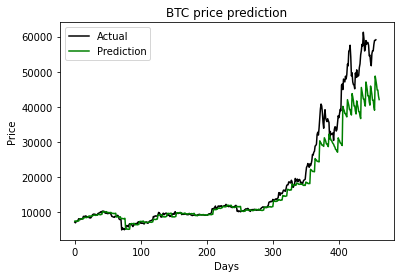

In [89]:
y_pred = []
for week in range(0, X_test.shape[0], 7):
    y_pred.append(model.predict(np.expand_dims(X_test[week], 0)))

y_pred = np.array(y_pred)
y_pred = np.expand_dims(y_pred.flatten(), 0)
actual_prices = raw_test_data["Close"].values
prediction_prices = scaler.inverse_transform(y_pred)[0]

plt.plot(actual_prices, color="black", label="Actual")
plt.plot(prediction_prices, color="green", label="Prediction")

plt.title(f"{crypto_currency} price prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()

In [ ]:
results = model.evaluate(X_train, y_train, batch_size=128)
print("test loss, test acc:", results)

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

In [90]:
#TODO try another method to not check price but check whether the price will go up or down
    
url = 'https://bitinfocharts.com/comparison/tweets-btc-dcr.html#alltime'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

scripts = soup.find_all('script')

for script in scripts:
    if 'd = new Dygraph(document.getElementById("container")' in script.text:
        StrList = script.text
        StrList = '[[' + StrList.split('[[')[-1]
        StrList = StrList.split(']]')[0] +']]'
        StrList = StrList.replace("new Date(", '').replace(')','')
        clean = re.sub("[\[\],\s]","",StrList)
        splitted = re.split("[\'\"]",clean)
        dataList = [s.replace("null", "000") for s in splitted if s != '']

date = []
tweet = []

for each in dataList:
    if (dataList.index(each) % 2) == 0:
        date.append(each)
    else:
        tweet.append(each)

df = pd.DataFrame(list(zip(date, tweet)), columns=["Date","Volume"])
volume = df[632:2550]["Volume"].values.astype(int)
to_impute = np.where(volume == 0)

avg_1 = (volume[539] + volume[558]) / 2
avg_2 = (volume[791] + volume[827]) / 2
avg_3 = (volume[1069] + volume[1071]) / 2
avg_4 = (volume[1659] + volume[1661]) / 2

for val in to_impute[0]:
    if val < 558:
        volume[val] = avg_1
    elif val < 827:
        volume[val] = avg_2
    elif val < 1071:
        volume[val] = avg_3
    else:
        volume[val] = avg_4
        
scaled_volume = scaler.fit_transform(volume.reshape(-1,1))

In [91]:
weights = [0.7,0.7,0.9,0.9,1.1,1.3,1.4]
mean, change, X_train = [], [], []

for x in range(training_days, len(volume) - predict_days - 140):
    mean.append(np.average(scaled_data[x:x+predict_days, 0], weights=weights) - scaled_data[x-1])
    X_train.append(scaled_data[x - training_days:x, 0])

X_train= np.array(X_train)
X_buff = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = []

for i, x in enumerate(range(training_days, len(volume) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_buff = np.array(X_train)
X_train = []

for i, x in enumerate(range(training_days, len(volume) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],2, scaled_volume[x - training_days:x][0], 1))

X_train = np.array(X_train)

In [54]:
big_inc = 0
small_inc = 0
small_dec = 0
big_dec = 0
y_train = []

for i, val in enumerate(mean):
    if val > 0.01:
        big_inc += 1
        y_train.append(0)
    elif val > 0:
        small_inc += 1
        y_train.append(1)
    elif val < -0.01:
        big_dec += 1
        y_train.append(3)
    else:
        small_dec += 1
        y_train.append(2)
    
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

In [94]:
test_start = dt.datetime(2020, 1,1)
test_end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)

model_inputs = scaled_data[1461-training_days:]

weights = [0.7,0.7,0.9,0.9,1.1,1.3,1.4]
mean, change, X_test = [], [], []

for x in range(training_days, len(model_inputs) - predict_days):
    mean.append(np.average(model_inputs[x:x+predict_days, 0], weights=weights) - model_inputs[x-1])
    X_test.append(model_inputs[x - training_days:x, 0])

X_test= np.array(X_test)
X_buff = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_buff = np.array(X_test)
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],2, scaled_volume[x - training_days:x][0], 1))

X_test = np.array(X_test)

In [56]:
big_inc = 0
small_inc = 0
small_dec = 0
big_dec = 0
y_test = []

for i, val in enumerate(mean):
    if val > 0.01:
        big_inc += 1
        y_test.append(0)
    elif val > 0:
        small_inc += 1
        y_test.append(1)
    elif val < -0.01:
        big_dec += 1
        y_test.append(3)
    else:
        small_dec += 1
        y_test.append(2)
    
y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [ ]:
dropout = 0.1
rec_dropout = 0.2

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=rec_dropout, dropout=dropout))
model.add(LSTM(units=256, return_sequences=True, recurrent_dropout=rec_dropout, dropout=dropout))
model.add(LSTM(units=256, recurrent_dropout=rec_dropout, dropout=dropout))
model.add(Dense(units=4, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])


history = model.fit(X_train, y_train, epochs=100, batch_size=256, callbacks=[EarlyStopping(monitor='loss',patience=10)])

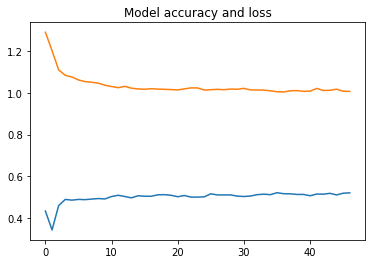

In [64]:
plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
plt.title('Model accuracy and loss')
plt.show()

In [63]:
results = model.evaluate(X_train, y_train, batch_size=128)
print("test loss, test acc:", results)

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

14/14 [==============================] - 1s 45ms/step - loss: 1.0012 - acc: 0.5202
test loss, test acc: [1.001193642616272, 0.5201636552810669]
4/4 [==============================] - 0s 48ms/step - loss: 1.4046 - acc: 0.3556
test loss, test acc: [1.4045770168304443, 0.35555556416511536]


In [ ]:
test_start = dt.datetime(2020, 1,1)
test_end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)

model_inputs = scaled_data[1461-training_days:]

weights = [0.7,0.7,0.9,0.9,1.1,1.3,1.4]
mean, change, X_test = [], [], []

for x in range(training_days, len(model_inputs) - predict_days):
    mean.append(np.average(model_inputs[x:x+predict_days, 0], weights=weights) - model_inputs[x-1])
    X_test.append(model_inputs[x - training_days:x, 0])

X_test= np.array(X_test)
X_buff = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_buff = np.array(X_test)
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],2, scaled_volume[x - training_days:x][0], 1))

X_test = np.array(X_test)

In [93]:
inc = 0
dec = 0
y_train = []

for i, val in enumerate(mean):
    if val >= 0:
        inc += 1
        y_train.append(0)
    else:
        dec += 1
        y_train.append(1)
    
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [95]:
inc = 0
dec = 0
y_test = []

for i, val in enumerate(mean):
    if val >= 0:
        inc += 1
        y_test.append(0)
    else:
        dec += 1
        y_test.append(1)
    
y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [107]:
dropout = 0.2
rec_dropout = 0.5

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=rec_dropout, dropout=dropout))
model.add(LSTM(units=64, return_sequences=True, recurrent_dropout=rec_dropout, dropout=dropout))
model.add(LSTM(units=64, recurrent_dropout=rec_dropout, dropout=dropout))
model.add(Dense(units=2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])


history = model.fit(X_train, y_train, epochs=100, batch_size=256, callbacks=[EarlyStopping(monitor='loss',patience=10)])

Epoch 1/100
7/7 [==============================] - 8s 348ms/step - loss: 0.6854 - acc: 0.5681
Epoch 2/100
7/7 [==============================] - 2s 346ms/step - loss: 0.6788 - acc: 0.5786
Epoch 3/100
7/7 [==============================] - 2s 343ms/step - loss: 0.6745 - acc: 0.5786
Epoch 4/100
7/7 [==============================] - 2s 346ms/step - loss: 0.6745 - acc: 0.5780
Epoch 5/100
7/7 [==============================] - 2s 348ms/step - loss: 0.6710 - acc: 0.5921
Epoch 6/100
7/7 [==============================] - 2s 345ms/step - loss: 0.6711 - acc: 0.5862
Epoch 7/100
7/7 [==============================] - 2s 349ms/step - loss: 0.6669 - acc: 0.5996
Epoch 8/100
7/7 [==============================] - 2s 345ms/step - loss: 0.6686 - acc: 0.5932
Epoch 9/100
7/7 [==============================] - 2s 345ms/step - loss: 0.6706 - acc: 0.5885
Epoch 10/100
7/7 [==============================] - 2s 340ms/step - loss: 0.6698 - acc: 0.5903
Epoch 11/100
7/7 [==============================] - 2s 346m

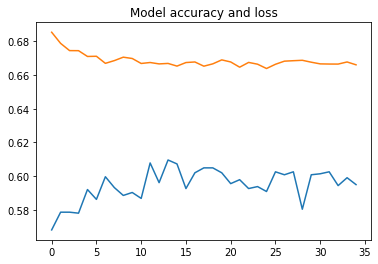

In [108]:
plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
plt.title('Model accuracy and loss')
plt.show()

In [109]:
results = model.evaluate(X_train, y_train, batch_size=128)
print("test loss, test acc:", results)

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

14/14 [==============================] - 1s 36ms/step - loss: 0.6647 - acc: 0.6026
test loss, test acc: [0.6646832823753357, 0.6025716066360474]
4/4 [==============================] - 0s 37ms/step - loss: 0.9555 - acc: 0.4933
test loss, test acc: [0.9555209875106812, 0.4933333396911621]
